In [12]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

In [19]:
from datasets import load_dataset
import pandas as pd

dataset_name = 'mediabiasgroup/BABE-v3'
dataset = load_dataset(dataset_name)
df_babe = pd.DataFrame(dataset['train'])
df_gpt = pd.read_csv('openAi_gpt4.csv')

df_gpt['label'] = df_gpt['label'].replace(
    {'NOT BIASED': 0, 'BIASED': 1})
df_gpt = df_gpt.rename(columns={'label': 'gpt4_label'})

df_babe = df_babe[['text', 'label']].merge(df_gpt[['text', 'gpt4_label']], on='text')
df_babe

text  label  gpt4_label
0     But instead of closing loopholes that allow cr...      1           1
1               "You think I'm joking," he continued. "      0           0
2     Yes, the rich are rich and want to stay that w...      1           1
3     Americans are carrying $1.57 trillion in outst...      0           0
4     Republican state legislators from Texas to Ari...      1           1
...                                                 ...    ...         ...
4116  Far-right talk show host Glenn Beck is being s...      1           1
4117  After President Donald Trump’s news conference...      1           1
4118  When Republicans warned Democrats that impeach...      0           1
4119  Sen. Tom Cotton (R-AR) says it “makes absolute...      1           1
4120  The march then continued to the United States ...      0           0

[4121 rows x 3 columns]

## Idea
We want a good pool for the ICL-Learning. Therefore, we want to cluster the articles in the BABE dataset. And then select a few articles from each cluster to be annotated by the ICL-Algorithm.

2 other papers use a pool size of 100 sentences, which seems like a reasonable size. Therefore, we choose this number as well.

We select from each cluster 100/num_clusters articles. This is done by selecting the articles with the smallest distance to the cluster center. Or randomly from the cluster.

We want to have:
- 100 sentences from each cluster
- 100 / num_clusters sentences from each cluster (nearest to cluster center or random selected)
- from each cluster the half of the sentences should be from the "BIASED" and the other half "NOT BIASED"


For the pool creation I use 8 clusters since this is the maximum number we want to do in the benchmark. The number of clusters can be changed in the code below.

In [14]:
model = SentenceTransformer("BAAI/llm-embedder")
# get embeddings
embeddings = model.encode(df_babe['text'], show_progress_bar=True)

Batches:   0%|          | 0/129 [00:00<?, ?it/s]

In [15]:
# cluster embeddings
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters, n_init='auto')
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# 2D PCA

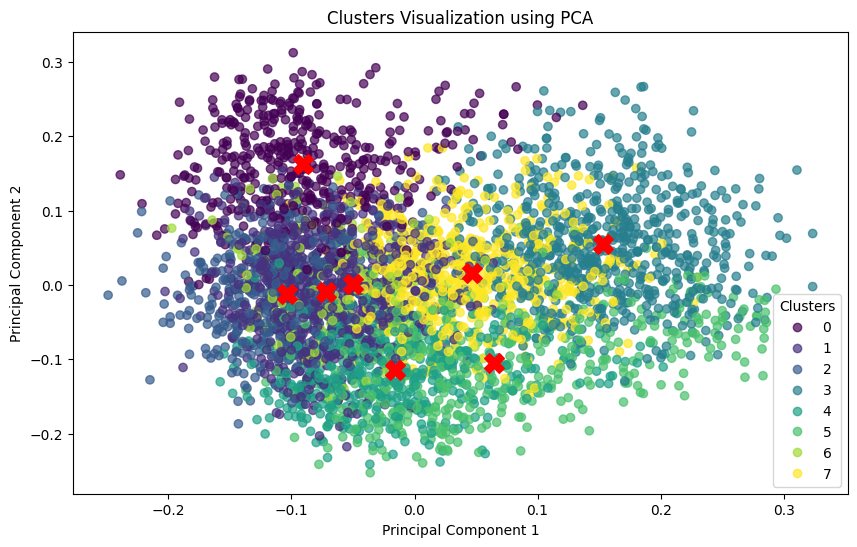

In [16]:
pca_2d = PCA(n_components=2)
plot_embeddings = pca_2d.fit_transform(embeddings)
pca_df = pd.DataFrame(
    {'PC1': plot_embeddings[:, 0], 'PC2': plot_embeddings[:, 1],
     'Cluster': cluster_assignment})

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'],
                      cmap='viridis', alpha=0.7)
plt.title('Clusters Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Clusters')

# highlight centroids
centroids = pca_2d.transform(clustering_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red',
            label='Centroids')

plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

# - Uncomment for plotly interactive visualization -
#
#Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(
    {'PC1': plot_embeddings[:, 0], 'PC2': plot_embeddings[:, 1],
     'Cluster': cluster_assignment,
     'Text': df_babe['text']})

# Add the centroids to the DataFrame
centroids_df = pd.DataFrame({'PC1': centroids[:, 0], 'PC2': centroids[:, 1],
                             'Cluster': ['Centroid'] * len(centroids),
                             'Text': [''] * len(centroids)})
combined_df = pd.concat([pca_df, centroids_df])

# Create an interactive 2D scatter plot with Plotly
fig = px.scatter(
    combined_df, x='PC1', y='PC2',
    color='Cluster', symbol='Cluster',
    opacity=0.7, size_max=10,
    hover_data={'Text': True},
    title='Interactive Clusters Visualization using 2D PCA'
)

# Show the plot
fig.show()

# Selection of sentences

In [24]:
def select_examples_random(sentences, clusters_assignment,
                           labels=[1, 0], pool_size=100,
                           seed=42
                           ):
    num_clusters = np.unique(clusters_assignment)

    state = np.random.RandomState(seed)
    pool = []
    for i in num_clusters:
        cluster_indices = np.where(clusters_assignment == i)[0]
        print("Cluster size: ", len(cluster_indices), " Cluster: ", i)
        for label in labels:
            label_indices = np.where(sentences['label'] == label)[0]
            label_cluster_indices = np.intersect1d(cluster_indices,
                                                   label_indices)

            pool.append(sentences.loc[label_cluster_indices].sample(
                n=pool_size // len(num_clusters) // len(labels),
                random_state=state))
            print("Label: ", label, " Cluster size: ",
                  len(label_cluster_indices))

    df_pool = pd.concat(pool)

    if len(df_pool) < pool_size:
        difference = pool_size - len(df_pool)
        remaining_sentences = sentences.drop(df_pool.index)
        for label in labels:
            label_indices = np.where(remaining_sentences['label'] == label)[0]
            pool.append(remaining_sentences.iloc[label_indices].sample(
                n=difference // len(labels),
                random_state=state))

    return pd.concat(pool)

pool = select_examples_random(df_babe, cluster_assignment)
pool

Cluster size:  429  Cluster:  0
Label:  1  Cluster size:  120
Label:  0  Cluster size:  309
Cluster size:  843  Cluster:  1
Label:  1  Cluster size:  492
Label:  0  Cluster size:  351
Cluster size:  449  Cluster:  2
Label:  1  Cluster size:  220
Label:  0  Cluster size:  229
Cluster size:  705  Cluster:  3
Label:  1  Cluster size:  448
Label:  0  Cluster size:  257
Cluster size:  486  Cluster:  4
Label:  1  Cluster size:  199
Label:  0  Cluster size:  287
Cluster size:  459  Cluster:  5
Label:  1  Cluster size:  184
Label:  0  Cluster size:  275
Cluster size:  191  Cluster:  6
Label:  1  Cluster size:  70
Label:  0  Cluster size:  121
Cluster size:  559  Cluster:  7
Label:  1  Cluster size:  308
Label:  0  Cluster size:  251


text  label  gpt4_label
1693  When two sadists in uniform shoved an elderly ...      1           1
1824  In addition to calling for severe funding cuts...      1           1
165   Chicago ended 2016 with more homicides than Ne...      1           1
2238  Romania's government, in trying to soften anti...      1           1
925   Speaking to host Trevor Noah, Obama sang the p...      1           1
...                                                 ...    ...         ...
3762  Turner, a black woman herself, criticized Bide...      0           1
1530  The president’s likely opponent in the Novembe...      1           1
1172  Lefty corporate financial muscle can be deploy...      1           1
306   The U.S. Congress is moving to extend by anoth...      0           0
420   Leaders of the 20 biggest economies vowed on S...      0           0

[100 rows x 3 columns]

In [25]:
pool['label'].value_counts()

label
1    50
0    50
Name: count, dtype: int64

In [27]:
pool.to_csv("pool.csv", index=False)